<a href="https://colab.research.google.com/github/zhuhfcod/capstone/blob/main/bert_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Model Using Main Text Feature

### In this part, we would like to use BERT to solve the text-only news classification task. This part will include data cleaning and data processing for text data, fine-tuning for the BERT model, final evaluation of the model and some error analysis

### Load the package

In [ ]:
Path = "/content/drive/MyDrive/capstone/dataset/train/text"

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np

import os
import tensorflow as tf
import transformers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the main text and data preprocessing

In [ ]:
directory = []
file = []
title = []
text = []
label = []
for dirname, _ , filenames in os.walk(Path):
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)
label = []
for i in file:
  label.append((int)(i[0]))


In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['title','text','label'], axis=1)
df.head()

,title,text,label
0,Kennedy to make temple address,"Charles Kennedy is set to address 2,000 peop...",3
1,Retirement age could be scrapped,"The ""myth that ageing is a barrier"" to contr...",3
2,Ruddock backs Yapp's credentials,Wales coach Mike Ruddock says John Yapp has ...,4
3,Radcliffe enjoys winning comeback,Paula Radcliffe made a triumphant return to ...,4
4,BAA support ahead of court battle,UK airport operator BAA has reiterated its s...,3


In [ ]:
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['label'])

In [ ]:
df['text'] = df['text'].apply(lambda text: str(text).lower())
df['title'] = df['title'].apply(lambda title: str(title).lower())

In [ ]:
# calculating the length of titles and main text
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_len'] = df['title'].apply(lambda x: len(str(x).split()))

In [ ]:
df.label = df.label.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [ ]:
print(f"The dataset contains { df.label.nunique() } unique categories")

The dataset contains 5 unique categories


In [ ]:
df.describe()

,label,categoryEncoded,text_len,title_len
count,1663.000000,1663.000000,1663.000000,1663.000000
mean,2.891762,1.891762,376.934456,5.248948
std,1.449204,1.449204,246.845772,0.844368
min,1.000000,0.000000,108.000000,1.000000
25%,2.000000,1.000000,240.000000,5.000000
50%,3.000000,2.000000,320.000000,5.000000
75%,4.000000,3.000000,463.500000,6.000000
max,5.000000,4.000000,4428.000000,9.000000


## Model training and Fine-tuning

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,  
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [ ]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
X_train,y_train = df['text'], df['categoryEncoded']

In [ ]:
X_train.astype('str')

0         charles kennedy is set to address 2,000 peop...
1         the "myth that ageing is a barrier" to contr...
2         wales coach mike ruddock says john yapp has ...
3         paula radcliffe made a triumphant return to ...
4         uk airport operator baa has reiterated its s...
                              ...                        
1658      a close associate of former yukos boss mikha...
1659      third seed tim henman slumped to a straight ...
1660      fast web access is encouraging more people t...
1661      for the umpteenth time, tony blair and gordo...
1662      the 10 authors shortlisted for a richard and...
Name: text, Length: 1663, dtype: object

In [ ]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=100)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=5, dtype = 'int32')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.4)(cls_token) 
    out = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss=loss, metrics=['accuracy'])
    return model

In [ ]:
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=100)
model.summary()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 100)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  335141888
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             100, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10
)

Epoch 1/10
51/51 [==============================] - 2816s 54s/step - loss: 0.2775 - accuracy: 0.9075
Epoch 2/10
51/51 [==============================] - 2778s 54s/step - loss: 0.0553 - accuracy: 0.9835
Epoch 3/10
51/51 [==============================] - 2768s 54s/step - loss: 0.0118 - accuracy: 0.9975
Epoch 4/10
51/51 [==============================] - 2769s 54s/step - loss: 0.0116 - accuracy: 0.9975
Epoch 5/10
51/51 [==============================] - 2768s 54s/step - loss: 0.0021 - accuracy: 1.0000
Epoch 6/10
51/51 [==============================] - 2764s 54s/step - loss: 4.0457e-04 - accuracy: 1.0000
Epoch 7/10
51/51 [==============================] - 2734s 54s/step - loss: 5.0122e-04 - accuracy: 1.0000
Epoch 8/10
51/51 [==============================] - 2740s 54s/step - loss: 1.8010e-04 - accuracy: 1.0000
Epoch 9/10
51/51 [==============================] - 2767s 54s/step - loss: 1.2087e-04 - accuracy: 1.0000
Epoch 10/10
51/51 [==============================] - 2760s 54s/step - loss:

In [ ]:
Path = "/content/drive/MyDrive/capstone/dataset/test/text"
directory = []
file = []
title = []
text = []
label = []
for dirname, _ , filenames in os.walk(Path):
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)
label = []
for i in file:
  label.append((int)(i[0]))


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['title','text','label'], axis=1)
df.head()

,title,text,label
0,MCI shares climb on takeover bid,Shares in US phone company MCI have risen on...,1
1,Veteran Martinez wins Thai title,Conchita Martinez won her first title in alm...,4
2,Players sought for $1m prize,UK gamers are getting a chance to take part ...,5
3,Teens 'know little' of politics,Teenagers questioned for a survey have shown...,3
4,Strike threat over pension plans,Millions of public service workers could str...,3


In [ ]:
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['label'])

In [ ]:
df['text'] = df['text'].apply(lambda text: str(text).lower())
df['title'] = df['title'].apply(lambda title: str(title).lower())

In [ ]:
X_test,y_test = df['text'], df['categoryEncoded']

In [ ]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=100)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=5, dtype = 'int32')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [ ]:
#making predictions
preds = model.predict(test_dataset,verbose = 1)
pred_classes = np.argmax(preds, axis = 1)

13/13 [==============================] - 235s 17s/step


## Model evaluation and Error analysis

In [ ]:
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [ ]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
0,shares in us phone company mci have risen on...,1,1
1,conchita martinez won her first title in alm...,4,4
2,uk gamers are getting a chance to take part ...,5,5
3,teenagers questioned for a survey have shown...,3,3
4,millions of public service workers could str...,3,3


In [ ]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.9735576923076923


In [ ]:
result_df[result_df['true_category']!=result_df['predicted_category']]

,description,true_category,predicted_category
5,a film based on the internet musings of the ...,2,5
72,campaigners against the expansion of britain...,3,1
101,shops all over the uk reported strong sales ...,1,2
120,the commission for africa's report will be r...,3,2
156,chancellor gordon brown has been given a £2....,1,3
273,violent video games should carry larger warn...,3,5
283,employers will no longer be able to force wo...,1,3
291,"the open society institute (osi), financed b...",1,3
302,former government communications chief alast...,4,3
319,the ministry of defence has been criticised ...,3,1


In [ ]:
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

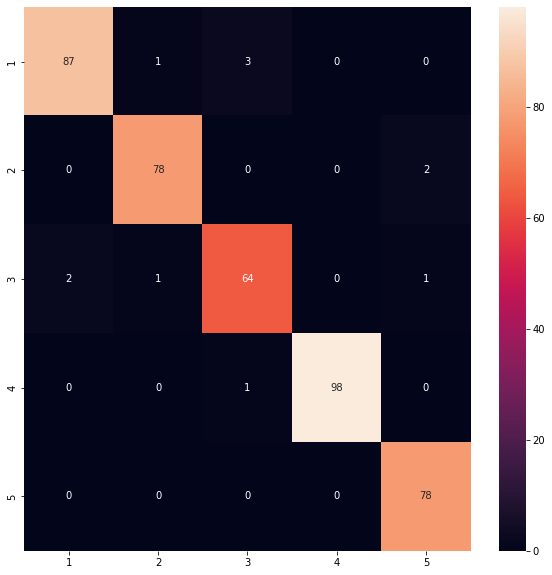

In [ ]:
df_cm = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df_cm, annot=True)